In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
from pydrake.all import (
    Meshcat,
    StartMeshcat,
    Simulator,
    DiagramBuilder,
    Diagram,
    MeshcatVisualizer,
    RigidTransform,
    RotationMatrix
)
from omegaconf import DictConfig
from src.setup import MakePandaManipulationStation
from src.modules.perception import MergePointClouds, LNDFGrasper
from src.kinematics import PandaGraspTrajectoryPlanner, CreatePandaTrajectoryController
import logging
import os
import random
import numpy as np
from manipulation.station import DepthImageToPointCloud
from debug import (
    visualize_camera_images,
    visualize_depth_images,
    visualize_point_cloud,
    draw_grasp_candidate,
)
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.utils import RenderDiagram

os.environ["CKPT_DIR"] = "/Users/ericchen/Eric/BallPitNDF/src/modules/lndf_robot/ckpts"

In [3]:
class NoDiffIKWarnings(logging.Filter):
    def filter(self, record):
        return not record.getMessage().startswith("Differential IK")


def get_directives(cfg: DictConfig) -> tuple[str, str]:
    # description of robot
    robot_directives = """
directives:
    - add_model:
        name: panda_arm
        file: package://drake_models/franka_description/urdf/panda_arm.urdf
        default_joint_positions:
            panda_joint1: [-1.57]
            panda_joint2: [0.1]
            panda_joint3: [0]
            panda_joint4: [-1.2]
            panda_joint5: [0]
            panda_joint6: [ 1.6]
            panda_joint7: [0]
    - add_weld:
        parent: world
        child: panda_arm::panda_link0
    - add_model:
        name: panda_hand
        file: package://drake_models/franka_description/urdf/panda_hand.urdf
    - add_weld:
        parent: panda_arm::panda_link8
        child: panda_hand::panda_hand
        X_PC:
            translation: [0, 0, 0]
            rotation: !Rpy { deg: [0, 0, -45] }
"""

    # description of objects in env
    env_directives = f"""
directives:
    - add_model:
        name: floor
        file: package://manipulation/floor.sdf
    - add_weld:
        parent: world
        child: floor::box
        X_PC:
            translation: [0, 0, -0.05]
    - add_model:
        name: bowl 
        file: file://{os.getcwd()}/src/assets/bowl/bowl.sdf
        default_free_body_pose:
            bowl_body_link:
                translation: [0.00061, 0.00578, 0.00468]

    - add_frame:
        name: camera0_origin
        X_PF:
            base_frame: world
            rotation: !Rpy {{deg: [-140.0, 0, 0.0]}}
            translation: [.5, -.6, 0.8]

    - add_model:
        name: camera0
        file: package://manipulation/camera_box.sdf

    - add_weld:
        parent: camera0_origin
        child: camera0::base

    - add_frame:
        name: camera1_origin
        X_PF:
            base_frame: world
            rotation: !Rpy {{deg: [-140., 0, 90.0]}}
            translation: [1.0, 0, 0.8]

    - add_model:
        name: camera1
        file: package://manipulation/camera_box.sdf

    - add_weld:
        parent: camera1_origin
        child: camera1::base

    - add_frame:
        name: camera2_origin
        X_PF:
            base_frame: world
            rotation: !Rpy {{deg: [-130., 0, -180.0]}}
            translation: [.5, .7, .8]

    - add_model:
        name: camera2
        file: package://manipulation/camera_box.sdf

    - add_weld:
        parent: camera2_origin
        child: camera2::base
"""
    for i in range(cfg.num_balls):
        env_directives += f"""
    - add_model:
        name: ball_{i}
        file: file://{os.getcwd()}/src/assets/sphere/sphere.sdf
        default_free_body_pose:
            sphere:
                translation: [{0.5 + np.random.choice([-1,1])*0.01 + 0.1*(random.random()-0.5)}, {np.random.choice([-1,1])*0.01 + 0.1*(random.random()-0.5)}, 0.5]
"""
    return robot_directives, env_directives



DEBUG_POSE = RigidTransform(
    R=RotationMatrix(
        [
            [0.9929763078689575, 0.03275140374898904, -0.11367256939411163],
            [0.027531351894140296, 0.8705389499664307, 0.491327166557312],
            [0.11504944413900373, -0.49100610613822937, 0.8635249137878418],
        ]
    ),
    p=[0.485896285623312, -0.29660160802304747, 0.09549740673974158],
)


def BuildPouringDiagram(meshcat: Meshcat, cfg: DictConfig) -> tuple[
    Diagram,
    Diagram,
]:
    builder = DiagramBuilder()

    robot_directives, env_directives = get_directives(cfg)
    panda_station = MakePandaManipulationStation(
        robot_directives=robot_directives,
        env_directives=env_directives,
        meshcat=meshcat,
        # time_step=1e-2,
    )
    station = builder.AddSystem(panda_station)

    plant = station.GetSubsystemByName("plant")
    plant_context = plant.CreateDefaultContext()
    panda_arm = plant.GetModelInstanceByName("panda_arm")
    plant.SetPositions(plant_context, panda_arm, [-1.57, 0.1, 0, -1.2, 0, 1.6, 0])

    merge_point_clouds = builder.AddNamedSystem(
        "merge_point_clouds",
        MergePointClouds(
            plant,
            plant.GetModelInstanceByName("bowl"),
            camera_body_indices=[
                plant.GetBodyIndices(plant.GetModelInstanceByName("camera0"))[0],
                plant.GetBodyIndices(plant.GetModelInstanceByName("camera1"))[0],
                plant.GetBodyIndices(plant.GetModelInstanceByName("camera2"))[0],
            ],
            meshcat=meshcat,
        ),
    )

    lndf_config = {
        "lndf": {
            "eval_dir": "outputs",
            "pose_optimizer": {
                "opt_type": "LNDF",
                "args": {
                    "opt_iterations": 500,
                    "rand_translate": True,
                    "use_tsne": False,
                    "M_override": 20,
                },
            },
            "query_point": {
                "type": "RECT",
                "args": {
                    "n_pts": 1000,
                    "x": 0.08,
                    "y": 0.04,
                    "z1": 0.05,
                    "z2": 0.02,
                },
            },
            "model": {
                "type": "CONV_OCC",
                "args": {
                    "latent_dim": 128,  # Number of voxels in convolutional occupancy network
                    "model_type": "pointnet",  # Encoder type
                    "return_features": True,  # Return latent features for evaluation
                    "sigmoid": False,  # Use sigmoid activation on last layer
                    "acts": "last",  # Return last activations of occupancy network
                },
                "ckpt": "lndf_weights.pth",
            },
        }
    }

    grasper = builder.AddNamedSystem(
        "grasper", LNDFGrasper(lndf_config, plant, meshcat, debug_pose=DEBUG_POSE)
    )

    builder.Connect(
        merge_point_clouds.GetOutputPort("point_cloud"),
        grasper.GetInputPort("merged_point_cloud"),
    )

    for i in range(3):
        point_cloud_port = f"camera{i}_point_cloud"
        builder.Connect(
            panda_station.GetOutputPort(point_cloud_port),
            merge_point_clouds.GetInputPort(point_cloud_port),
        )

    builder.Connect(
        panda_station.GetOutputPort("body_poses"),
        merge_point_clouds.GetInputPort("body_poses"),
    )

    # trajectory planner
    trajectory_planner = builder.AddNamedSystem(
        "trajectory_planner",
        PandaGraspTrajectoryPlanner(plant)
    )

    builder.Connect(
        grasper.GetOutputPort("grasp_pose"),
        trajectory_planner.GetInputPort("grasp_pose"),
    )

    # trajectory controller
    panda_arm = plant.GetModelInstanceByName("panda_arm")
    plant_context = plant.CreateDefaultContext()
    initial_panda_arm_position = plant.GetPositions(plant_context, panda_arm)
    trajectory_controller = builder.AddNamedSystem(
        "trajectory_controller",
        CreatePandaTrajectoryController(plant, initial_panda_arm_position=initial_panda_arm_position)
    )

    builder.Connect(
        trajectory_planner.GetOutputPort("panda_arm_trajectory"),
        trajectory_controller.GetInputPort("panda_arm_trajectory"),
    )

    builder.Connect(
        station.GetOutputPort("panda_arm.position_estimated"),
        trajectory_controller.GetInputPort("panda_arm.position"),
    )

    builder.Connect(
        trajectory_controller.GetOutputPort("panda_arm.position_commanded"),
        station.GetInputPort("panda_arm.position"),
    )


    # Debug: visualize camera images
    # visualize_camera_images(station)

    # Debug: visualize depth images
    # visualize_depth_images(station)

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder, station.GetOutputPort("query_object"), meshcat
    )

    return builder.Build(), None, visualizer


def pouring_demo(cfg: DictConfig, meshcat: Meshcat) -> bool:

    meshcat.Delete()
    diagram, plant, visualizer = BuildPouringDiagram(meshcat, cfg)

    # debug

    grasper = diagram.GetSubsystemByName("grasper")
    context = diagram.CreateDefaultContext()
    grasper_context = grasper.GetMyContextFromRoot(context)
    grasp = grasper.GetOutputPort("grasp_pose").Eval(grasper_context)
    # draw_grasp_candidate(meshcat, grasp)


    # calc pregrasp pose
    X_GPregrasp = RigidTransform(R=RotationMatrix(
                np.array(
                    [
                        [0, 1, 0],  # X becomes Z
                        [0, 0, 1],  # Y becomes X
                        [1, 0, 0],  # Z becomes Y
                    ]
                )
            )
                                 , p=[0, -0.25, 0.25])
    # X_GPregrasp = RigidTransform(p=[0, -0.5, 0])
    X_WG = grasp
    X_WPregrasp = X_WG.multiply(X_GPregrasp)    

    AddMeshcatTriad(meshcat, path="/X_WGrasp", X_PT=X_WG)
    AddMeshcatTriad(meshcat, path="/X_WPregrasp", X_PT=X_WPregrasp)

    # trajectory planner
    trajectory_planner = diagram.GetSubsystemByName("trajectory_planner")
    trajectory_planner_context = trajectory_planner.GetMyContextFromRoot(context)

    # draw pose of gripper in initial pose
    station = diagram.GetSubsystemByName("PandaManipulationStation")
    plant = station.GetSubsystemByName("plant")
    plant_context = plant.GetMyContextFromRoot(context)

    # model instances
    panda_arm = plant.GetModelInstanceByName("panda_arm")
    panda_hand = plant.GetModelInstanceByName("panda_hand")

    # bodies
    panda_gripper_body = plant.GetBodyByName("panda_link7")
    panda_hand_body = plant.GetBodyByName("panda_hand")


    # trajectory poses
    X_WHinit = plant.EvalBodyPoseInWorld(plant_context, panda_hand_body)
    AddMeshcatTriad(meshcat, path="/X_WHinit", X_PT=X_WHinit)


    # trajectory output from planner
    panda_arm_traj = trajectory_planner.GetOutputPort("panda_arm_trajectory").Eval(trajectory_planner_context)
    print("Trajectory Duration: ", panda_arm_traj.end_time())


    plant_mutable_context = plant.GetMyMutableContextFromRoot(context)
    plant.SetPositions(plant_mutable_context, panda_arm, [-1.57, 0.1, 0, -1.2, 0, 1.6, 0])


    # set initial integrator value
    integrator = diagram.GetSubsystemByName("trajectory_controller").GetSubsystemByName("panda_arm_integrator")
    initial_panda_arm_position = plant.GetPositions(plant_context, panda_arm)
    print("initial_panda_arm_position: ", initial_panda_arm_position)
    integrator.set_integral_value(
        integrator.GetMyContextFromRoot(context), 
        initial_panda_arm_position
    )

    # merge_point_clouds = diagram.GetSubsystemByName('merge_point_clouds')
    # context = merge_point_clouds.GetMyContextFromRoot(diagram.CreateDefaultContext())
    # pc = merge_point_clouds.GetOutputPort('point_cloud').Eval(context)
    # np.save('outputs/point_cloud.npy', pc.xyzs())

    simulator = Simulator(diagram, context)
    simulator.set_target_realtime_rate(0)

    visualizer.StartRecording()
    simulator.AdvanceTo(2.0)

    # get the position of the panda arm
    # station.GetOutputPort("panda_arm.position_estimated").Eval(station_context)

    meshcat.Flush()  # Wait for the large object meshes to get to meshcat.
    visualizer.PublishRecording()
    return True

In [4]:
cfg = DictConfig(
        {
            # 'num_balls': args.n,
            "num_balls": 5,
            "bowl_id": 1,
            "max_time": 60.0,
        }
    )

logging.getLogger("drake").addFilter(NoDiffIKWarnings())

meshcat = StartMeshcat()
pouring_demo(cfg, meshcat)

INFO:drake:Meshcat listening for connections at http://localhost:7001
Failed to load material file(s). Use default material.

Failed to load material file(s). Use default material.

Failed to load material file(s). Use default material.

Failed to load material file(s). Use default material.

Failed to load material file(s). Use default material.



Using CONV OCC
model_ckpt:  /Users/ericchen/Eric/BallPitNDF/src/modules/lndf_robot/ckpts/lndf_weights.pth
Using Occ Net optimizer


/Users/ericchen/Eric/BallPitNDF/src/modules/lndf_robot/eval/pose_selector.py:86: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Trajectory Duration:  1.0
initial_panda_arm_position:  [-1.57  0.1   0.   -1.2   0.    1.6   0.  ]


t:  0.0 v:  [ 0.18291143 -1.30987637  0.4278786  -3.14800763  1.39124946  1.31278683
 -1.44630366] V_G:  [ 0.52610532 -0.95543559  2.36251669  0.47888631  0.10655359 -0.55148431]
t:  5e-05 v:  [ 0.18291143 -1.30987637  0.4278786  -3.14800763  1.39124946  1.31278683
 -1.44630366] V_G:  [ 0.52610532 -0.95543559  2.36251669  0.47888631  0.10655359 -0.55148431]
t:  0.0001 v:  [ 0.18291143 -1.30987637  0.4278786  -3.14800763  1.39124946  1.31278683
 -1.44630366] V_G:  [ 0.52610532 -0.95543559  2.36251669  0.47888631  0.10655359 -0.55148431]
t:  0.0001 v:  [ 0.18291127 -1.30987642  0.42787851 -3.14800768  1.39124972  1.31278672
 -1.44630384] V_G:  [ 0.52610532 -0.95543559  2.36251669  0.47888631  0.10655359 -0.55148431]
t:  0.00015000000000000001 v:  [ 0.18291127 -1.30987642  0.42787851 -3.14800768  1.39124972  1.31278672
 -1.44630384] V_G:  [ 0.52610532 -0.95543559  2.36251669  0.47888631  0.10655359 -0.55148431]
t:  0.0002 v:  [ 0.18291127 -1.30987642  0.42787851 -3.14800768  1.39124972  1

True

In [12]:
from pydrake.all import (PiecewisePose)

traj = PiecewisePose.MakeLinear(
    times=[0, 1.0],
    poses=[RigidTransform(), RigidTransform(p=[0.1, 0.1, 0.1])]
)
traj_V = traj.MakeDerivative()


traj_V.value(100)

array([[0. ],
       [0. ],
       [0. ],
       [0.1],
       [0.1],
       [0.1]])

Failed to load material file(s). Use default material.

Failed to load material file(s). Use default material.

Failed to load material file(s). Use default material.

Failed to load material file(s). Use default material.

Failed to load material file(s). Use default material.



Using CONV OCC
model_ckpt:  /Users/ericchen/Eric/BallPitNDF/src/modules/lndf_robot/ckpts/lndf_weights.pth
Using Occ Net optimizer


/Users/ericchen/Eric/BallPitNDF/src/modules/lndf_robot/eval/pose_selector.py:86: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Loading grasp demo from fname: src/demos/lndf_mug_handle_demos/grasp_demo_928a383f79698c3fb6d9bc28c8d8a2c4.npz
Loading grasp demo from fname: src/demos/lndf_mug_handle_demos/grasp_demo_7d6baadd51d0703455da767dfc5b748e.npz
Loading grasp demo from fname: src/demos/lndf_mug_handle_demos/grasp_demo_8f550770386a6cf82f23d8349a133d2b.npz
Loading grasp demo from fname: src/demos/lndf_mug_handle_demos/grasp_demo_586e67c53f181dc22adf8abaa25e0215.npz
Loading grasp demo from fname: src/demos/lndf_mug_handle_demos/grasp_demo_a0c78f254b037f88933dc172307a6bb9.npz
Loading grasp demo from fname: src/demos/lndf_mug_handle_demos/grasp_demo_6c379385bf0a23ffdec712af445786fe.npz
Loading grasp demo from fname: src/demos/lndf_mug_handle_demos/grasp_demo_7a8ea24474846c5c2f23d8349a133d2b.npz
Loading grasp demo from fname: src/demos/lndf_mug_handle_demos/grasp_demo_187859d3c3a2fd23f54e1b6f41fdd78a.npz
Loading grasp demo from fname: src/demos/lndf_mug_handle_demos/grasp_demo_73b8b6456221f4ea20d3c05c08e26f.npz
Loa

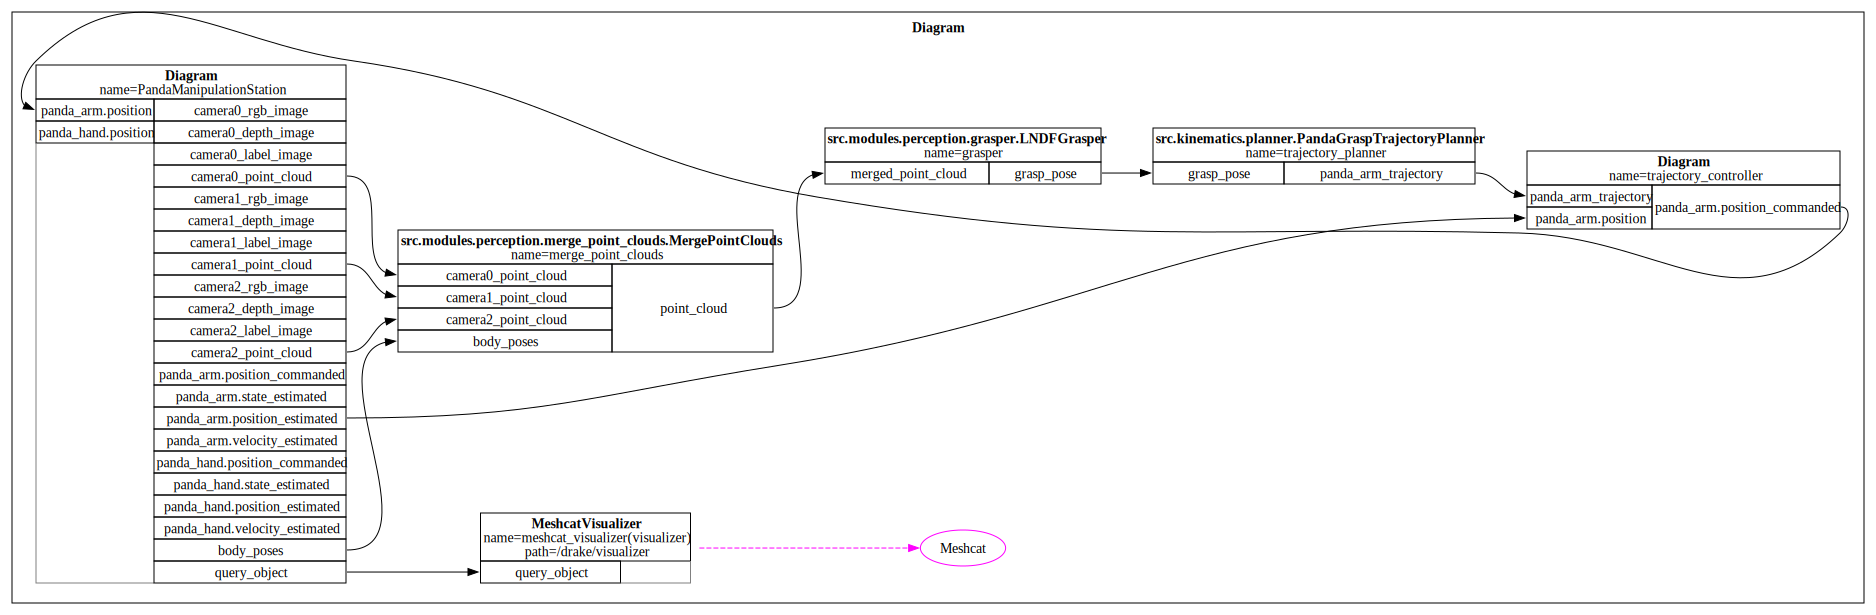

In [33]:
diagram, plant, visualizer = BuildPouringDiagram(meshcat, cfg)
RenderDiagram(diagram, max_depth=1)